# Predicting restaurant ratings from Yelp reviews with NLP


In [1]:
#Load libraries

from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import dill

## Load and parse the data


In [2]:
#Open the business.csv file with information on businesses found on Yelp

business=pd.read_csv('business.csv',low_memory=False)

In [3]:
#Keep only restaurants

restaurants=business[(business.categories.str.contains('Restaurants'))  | (business.categories.str.contains('Food'))]
restaurants.shape

(74587, 60)

In [4]:
#Since we need only text, stars and mapping to business, preprocess the chunks for memory efficiency
def review_preprocess(chunk):
    chunk=chunk[['stars','text','business_id']]
    return chunk

In [5]:
chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in pd.read_csv('review.csv', chunksize=250000):  
    # perform data filtering 
    chunk_filter = review_preprocess(chunk)
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk_filter)
    
# concat the list into dataframe 
reviews = pd.concat(chunk_list)
reviews

,stars,text,business_id
0,1.0,Total bill for this horrible service? Over $8G...,ujmEBvifdJM6h6RLv4wQIg
1,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,NZnhc2sEQy3RmzKTZnqtwQ
2,5.0,I have to say that this office really has it t...,WTqjgwHlXbSFevF32_DJVw
3,5.0,Went in for a lunch. Steak sandwich was delici...,ikCg8xy5JIg_NGPx-MSIDA
4,1.0,Today was my second out of three sessions I ha...,b1b1eb3uo-w561D0ZfCEiQ
...,...,...,...
6685895,5.0,I have been coming here for years and this pla...,RXBFk3tVBxiTf3uOt9KExQ
6685896,1.0,I think this owner and the owner of Amy's Baki...,yA6dKNm_zl1ucZCnwW8ZCg
6685897,5.0,"Off the grid Mexican in Vegas. Very tasty, qua...",a192hdM0_UVCYLwPJv1Qwg
6685898,5.0,We hired Taco Naco to cater our family party a...,kOo4ZY2UQAX4j312mzQ8mA


In [6]:
rest_reviews = pd.merge(how='left',left=restaurants[['business_id','name']], right=reviews, left_on='business_id', right_on='business_id')


In [8]:
rest_reviews.dropna(inplace=True)

In [9]:
rest_reviews

,business_id,name,stars,text
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,My girlfriend and I went for dinner at Emerald...
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,We've always been there on a Sunday so we were...
2,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,"***No automatic doors, not baby friendly!*** I..."
3,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,1.0,"Horrible service,\r\nI went there tonight with..."
4,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,4.0,One of the gauges of a good Chinese restaurant...
...,...,...,...,...
4580296,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,5.0,When I write a review on someplace that I have...
4580297,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,5.0,We stopped in at Tre Belle on a Tuesday evenin...
4580298,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,3.0,I wasnt impressed. The place is beautiful and ...
4580299,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,1.0,Last night some friends and I dined at this es...


The dataset has more than 4.5 million reviews on restaurants with their corresponding rating. We will use this dataset to build the model of the analysis

(array([ 544139.,       0.,  420637.,       0.,       0.,  604359.,
              0., 1191087.,       0., 1820077.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

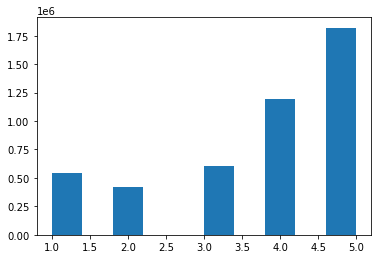

In [10]:
plt.hist(rest_reviews.stars)

In [11]:
rest_reviews.groupby(['stars']).count()

,business_id,name,text
stars,,,
1.0,544139,544139,544139
2.0,420637,420637,420637
3.0,604359,604359,604359
4.0,1191087,1191087,1191087
5.0,1820077,1820077,1820077


In [12]:
#Keep a smaller and balanced dataset

# 50000 reviews for each star

chunk_list = []

for i in range(5):
    chunk_list.append(rest_reviews[rest_reviews.stars==i+1].sample(50000))
    
small_dataset = pd.concat(chunk_list)



In [13]:
small_dataset

,business_id,name,stars,text
621773,FMo1PJTUV5OpyiZlnTM1Rg,Sharky's Woodfired Mexican Grill,1.0,5 Stars on Yelp??? Something is wrong!!!! \r\n...
1455755,PaKG_CtfPbjWQUcdro81rw,Drai's After Hours,1.0,ALRIGHT! The only reason it gets one star THIS...
566198,ZV89e6dYFymcBAUmRzKGwA,Tanaka Grill & Sushi,1.0,I expected to go to Tanaka's with my friend to...
950779,PglC8rgguMIlT621p1BLdQ,Yum Cha,1.0,The food if it ever arrives is good. Maybe bec...
2230038,n44grut83X0UiRZCA-O1fw,Patisserie La Cigogne,1.0,The food was OK. The service was AWFUL.\r\n\r\...
...,...,...,...,...
3681107,ZumOnWbstgsIE6bJlxw0_Q,Jacobs & Co. Steakhouse,5.0,Honestly one of the best experiences at a stea...
323980,SyXRHl0ewl-Yu2mkf1EZfw,Bakes & Goods,5.0,"I had a nice experience. Walked in, couldn't d..."
2686937,wl0QZqAzr1DelslQ02JGCQ,Cornish Pasty,5.0,Was looking for a unique place to have my last...
2152534,DcdjPu2wFoMp-G3K7PnYqQ,Anna's Pizzeria,5.0,There is a reason why Anna's pizza has won so ...


In [20]:
#Do not use 

stars = rest_reviews.stars
text = rest_reviews.text


In [14]:
#Use subset

stars = small_dataset.stars
text = small_dataset.text

In [15]:
text_train, text_test, stars_train, stars_test = train_test_split(text, stars, test_size=0.2)

(array([39961.,     0., 40071.,     0.,     0., 39979.,     0., 40035.,
            0., 39954.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

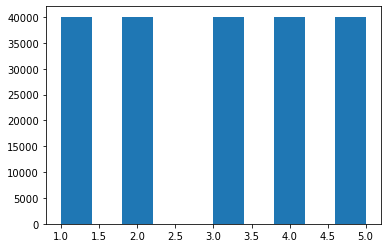

In [16]:
plt.hist(stars_train)

(array([10039.,     0.,  9929.,     0.,     0., 10021.,     0.,  9965.,
            0., 10046.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

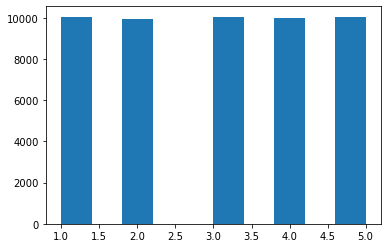

In [17]:
plt.hist(stars_test)

## RANDOM FOREST REGRESSOR -- RFR

In [37]:
# RFR
X = CountVectorizer(min_df=7,max_df=0.3).fit_transform(text)
rfr=RandomForestRegressor()

param_grid = { 
    'n_estimators': [10, 50],
    'max_depth' : [4,8],
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5)
CV_rfr.fit(X, stars)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 8], 'n_estimators': [10, 50]})

In [38]:

CV_rfr.best_params_


{'max_depth': 4, 'n_estimators': 10}

In [40]:
# input the best parameters
#rfr_best=RandomForestRegressor(n_estimators=10,max_depth=4)


rfr_best = Pipeline([
    ('Vec',CountVectorizer(min_df=7,max_df=0.3)),
    ('RFR',RandomForestRegressor(n_estimators=10,max_depth=4))

])


In [41]:

rfr_best.fit(text_train,stars_train)

Pipeline(steps=[('Vec', CountVectorizer(max_df=0.3, min_df=7)),
                ('RFR', RandomForestRegressor(max_depth=4, n_estimators=10))])

In [42]:
pred=rfr_best.predict(text_test)

In [45]:
print('MSE for RFR unigram =',metrics.mean_squared_error(stars_test,pred))
print('R2 for RFR unigram =',metrics.r2_score(stars_test,pred))

MSE for RFR unigram = 1.5828348740179616
R2 for RFR unigram = 0.21042976256150658


### normalized_unigram with TF-IDF -- RFR

In [47]:
# RFR
V = CountVectorizer(min_df=7,max_df=0.3).fit_transform(text)
X = TfidfTransformer().fit_transform(V)
rfr=RandomForestRegressor()

param_grid_norm = { 
    'n_estimators': [10, 50],
    'max_depth' : [4,8],
}

CV_rfr_norm = GridSearchCV(estimator=rfr, param_grid=param_grid_norm, cv= 5)
CV_rfr_norm.fit(X, stars)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 8], 'n_estimators': [10, 50]})

In [48]:

CV_rfr_norm.best_params_


{'max_depth': 4, 'n_estimators': 10}

In [111]:
# input the best parameters
#run again


rfr_best_norm = Pipeline([
    ('Vec',CountVectorizer(min_df=7,max_df=0.3)),
    ('tfidf',TfidfTransformer()),
    ('RFR',RandomForestRegressor(n_estimators=10,max_depth=20))

])


In [112]:

rfr_best_norm.fit(text_train,stars_train)

Pipeline(steps=[('Vec', CountVectorizer(max_df=0.3, min_df=7)),
                ('tfidf', TfidfTransformer()),
                ('RFR', RandomForestRegressor(max_depth=20, n_estimators=10))])

In [113]:
pred_norm=rfr_best_norm.predict(text_test)
print('MSE for RFR normalized unigram =',metrics.mean_squared_error(stars_test,pred_norm))
print('R2 for RFR normalized unigram =',metrics.r2_score(stars_test,pred_norm))

MSE for RFR normalized unigram = 1.0507326049808303
R2 for RFR normalized unigram = 0.47585992321921344


### bigram_model -- RFR

In a bigram model, we'll consider both single words and pairs of consecutive words that appear.  This is going to be a much higher dimensional problem (large $p$) so we should be careful about overfitting. To avoid memory issues we are using the HashingVectorizer instead of the CountVectorizer


In [61]:
# RFR
X = CountVectorizer(ngram_range=(1,2),min_df=7,max_df=0.3).fit_transform(text)
rfr=RandomForestRegressor()

param_grid_bi = { 
    'n_estimators': [10],
    'max_depth' : [10,20],
}

CV_rfr_bi = GridSearchCV(estimator=rfr, param_grid=param_grid_bi, cv= 5)
CV_rfr_bi.fit(X, stars)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20], 'n_estimators': [10]})

In [62]:

CV_rfr_bi.best_params_


{'max_depth': 10, 'n_estimators': 10}

In [66]:
# input the best parameters

rfr_best_bi = Pipeline([
    ('Vec',CountVectorizer(ngram_range=(1,2),min_df=7,max_df=0.3)),
    ('RFR',RandomForestRegressor(n_estimators=10,max_depth=20))

])


In [67]:

rfr_best_bi.fit(text_train,stars_train)

Pipeline(steps=[('Vec',
                 CountVectorizer(max_df=0.3, min_df=7, ngram_range=(1, 2))),
                ('RFR', RandomForestRegressor(max_depth=20, n_estimators=10))])

In [68]:
pred_bi=rfr_best_bi.predict(text_test)
print('MSE for RFR bigram =',metrics.mean_squared_error(stars_test,pred_bi))
print('R2 for RFR bigram =',metrics.r2_score(stars_test,pred_bi))

MSE for RFR bigram = 1.0253149816826812
R2 for RFR bigram = 0.488539071999716


### 2 examples


#### bad example

In [105]:
print('14th review text:',text_test[14:15])

14th review text: 1773892    So I've been here quite a few times, and the m...
Name: text, dtype: object


In [98]:
print('14th review star:',stars_test[14:15])
print('14th review text:',text_test[14:15])
print('14th review pred_bi:',pred_bi[14:15])


14th review star: 1773892    1.0
Name: stars, dtype: float64
14th review text: 1773892    So I've been here quite a few times, and the m...
Name: text, dtype: object
14th review pred_bi: [1.72579848]


#### good example

In [92]:
print('2008th review star:',stars_test[2008:2009])
print('2008th review text:',text_test[2008:2009])
print('2008th review pred_bi:',pred_bi[2008:2009])

2008th review star: 4030637    5.0
Name: stars, dtype: float64
2008th review text: 4030637    I really liked this place. The atmosphere was ...
Name: text, dtype: object
2008th review pred_bi: [4.52004891]


### Bigram model with TFIDF

In [ ]:
# RFR
V = CountVectorizer(ngram_range=(1,2),min_df=7,max_df=0.2)
X = TfidfTransformer().fit_transform(V)
rfr=RandomForestRegressor()

param_grid_binorm = { 
    'n_estimators': [10],
    'max_depth' : [10,20],
}

CV_rfr_binorm = GridSearchCV(estimator=rfr, param_grid=param_grid_binorm, cv= 5)
CV_rfr_binorm.fit(X, stars)


In [ ]:

CV_rfr_binorm.best_params_


In [106]:
# input the best parameters

rfr_best_binorm = Pipeline([
    ('Vec',CountVectorizer(ngram_range=(1,2),min_df=7,max_df=0.3)),
    ('tfidf',TfidfTransformer()),
    ('RFR',RandomForestRegressor(n_estimators=10,max_depth=20))

])


In [107]:

rfr_best_binorm.fit(text_train,stars_train)

Pipeline(steps=[('Vec',
                 CountVectorizer(max_df=0.3, min_df=7, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('RFR', RandomForestRegressor(max_depth=20, n_estimators=10))])

In [110]:
pred_binorm=rfr_best_binorm.predict(text_test)
print('MSE for RFR bigram_tfidf =',metrics.mean_squared_error(stars_test,pred_binorm))
print('R2 for RFR bigram_tfidf =',metrics.r2_score(stars_test,pred_binorm))

MSE for RFR bigram_tfidf = 1.0081564562194263
R2 for RFR bigram_tfidf = 0.49709831039312213
